In [1]:
'''This script demonstrates how to build a variational autoencoder with Keras.

 KL-Divergence
 
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics

import tensorflow.keras as keras
import tensorflow as tf
from scipy.optimize import fmin
from scipy.stats import entropy
from scipy.stats import norm
import sys


# show the network
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot


------------ Sanity check start -------------
Calculate KL divergence between uni-modal distributions.
Numeric values should be somehow equal to the analytic values!
KLD left vs. middle (numeric): 4.499999999998725
KLD right vs. middle (numeric): 4.499999999998716
KLD left vs. middle (analytic): 4.5
KLD right vs. middle (analytic): 4.5
------------ Sanity check end -------------

A DK-minimization approach that samples either N_1 or N_2 will try to put theresulting N into the middle of both distributions, because it does not see any relationbetween these distributionsThis is because the KL defined on single Gaussian does only cover one Gaussian at a time,Therefore, it is obvious that the minimum resulting N has mu=0.5(mu_1 + mu_2) and std = sqrt(std_1^2 + std_2^2)

mu_mid, mu_left, mu_right, std_mid, std_left, std_right: 0.0, -3.0, 3.0, 0.5, 1.0, 1.0
1. KLD joint vs. middle (sum of single KLD, i.e. optimized by the NN): 37.613705638880106
2. KLD joint vs. middle (numeric and corrent KL

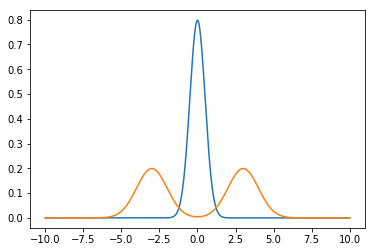

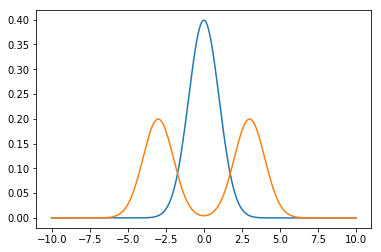

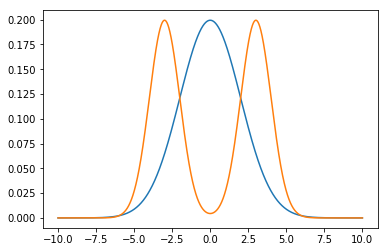

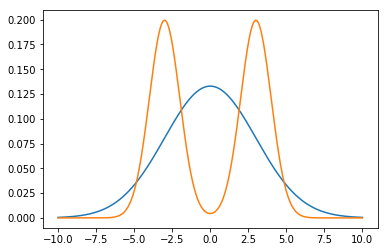

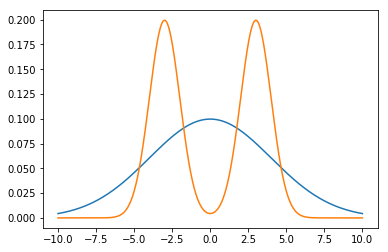

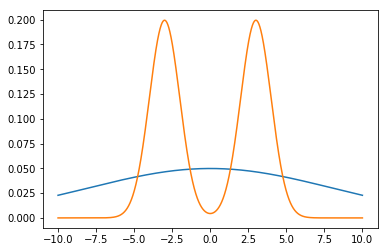

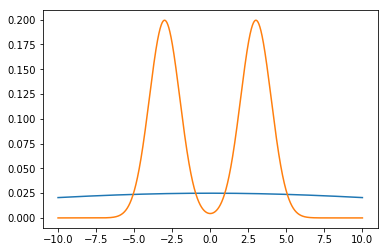

In [2]:
def dkl_gauss(mu1, std1, mu2, std2):
    # DKL(N(mu1, std1)||N(mu2, std2)) 
    return np.log(std2) - np.log(std1) + std1**2 / (2 * std2**2) + (mu1 - mu2)**2 / (2 * std2**2) - 1/2

def dkl_gauss_opt(mu_std, mu1, std1):
    # returns DKL(N(mu_std)||N(mu1, std1))
    return dkl_gauss(mu_std[0], mu_std[1], mu1, std1)

def dkl_gauss_opt2(mu_std, mu1, std1, mu2, std2):
    # returns the sum DKL(N(mu_std)||N(mu1, std1)) + DKL(N(mu_std)||N(mu2, std2))
    #return dkl_gauss(mu_std[0], mu_std[1], mu1, std1) + dkl_gauss(mu_std[0], mu_std[1], mu2, std2)
    return dkl_gauss(mu1, std1, mu_std[0], mu_std[1]) + dkl_gauss(mu2, std2, mu_std[0], mu_std[1])

def norm_multi(x, pdf):
    # returns normalized PDF of all scipy continues random variable (rv_continuous) PDF functions in the list pdf
    r = np.zeros(pdf[0].pdf(x).shape)
    for f in pdf:
        r += f.pdf(x)
    return r / np.float(len(pdf))

def entropy_sanity(pk, qk):
    # Calculate KL divergence between the ground-truth pk and approximator qk
    # remove zero values because it causes divide by zero errors: https://datascience.stackexchange.com/questions/11320/kl-divergence-returns-infinity
    pk[pk <= sys.float_info.min] = sys.float_info.min
    qk[qk <= sys.float_info.min] = sys.float_info.min
    return entropy(pk = pk, qk = qk)


def entropy_opt(mu_std, qk, x):
    # returns DKL(N(mu_std)||qk)
    rv = norm(loc = mu_std[0], scale = mu_std[1])
    return entropy_sanity(pk = rv.pdf(x), qk = qk)


# def entropy_opt2(mu_std, mu1 = mu1, std1 = std1, mu2 = mu2, std2 = std2):

#initialize a normal distribution with frozen in mean=-1, std. dev.= 1
rv = norm(loc = 0., scale = 1.0)
rv1 = norm(loc = -3., scale = 1.0)
rv2 = norm(loc = 3., scale = 1.0)
x = np.arange(-10, 10, .001)

# plot the pdfs of these normal distributions 
#plt.plot(x, rv.pdf(x), x, norm_multi(x, [rv1, rv2]))
#plt.show()

print("------------ Sanity check start -------------")
print("Calculate KL divergence between uni-modal distributions.")
print("Numeric values should be somehow equal to the analytic values!")
# numeric
dkl_num_LvsM = entropy_sanity(pk = rv.pdf(x), qk = rv1.pdf(x))
dkl_num_RvsM = entropy_sanity(pk = rv.pdf(x), qk = rv2.pdf(x))
print("KLD left vs. middle (numeric): " + str(dkl_num_LvsM))
print("KLD right vs. middle (numeric): " + str(dkl_num_RvsM))
# analytic
print("KLD left vs. middle (analytic): " + str(dkl_gauss_opt([rv.mean(), rv.std()], mu1 = rv1.mean(), std1 = rv1.std())))
print("KLD right vs. middle (analytic): " + str(dkl_gauss_opt([rv.mean(), rv.std()], mu1 = rv1.mean(), std1 = rv2.std())))
print("------------ Sanity check end -------------")
print("")

print("A DK-minimization approach that samples either N_1 or N_2 will try to put the" +
    "resulting N into the middle of both distributions, because it does not see any relation" +
    "between these distributions" +
    "This is because the KL defined on single Gaussian does only cover one Gaussian at a time," +
    "Therefore, it is obvious that the minimum resulting N has mu=0.5(mu_1 + mu_2) and std = sqrt(std_1^2 + std_2^2)")
print("")

def KLD_eval(rv, rv1, rv2, plot = True, x = np.arange(-10, 10, .001)):
    print("mu_mid, mu_left, mu_right, std_mid, std_left, std_right: "
          + str(rv.mean()) + ", " + str(rv1.mean()) + ", " + str(rv2.mean()) + ", "
          + str(rv.std()) + ", " + str(rv1.std()) + ", " + str(rv2.std()))
    r_naive = dkl_gauss_opt2([rv.mean(), rv.std()], mu1 = rv1.mean(), std1 = rv1.std(),mu2 = rv2.mean(), std2 = rv2.std())
    #r_full = entropy_sanity(pk = rv.pdf(x), qk = norm_multi(x, [rv1, rv2]))
    r_full = entropy_sanity(pk = norm_multi(x, [rv1, rv2]), qk = rv.pdf(x))
    print("1. KLD joint vs. middle (sum of single KLD, i.e. optimized by the NN): " + str(r_naive))
    print("2. KLD joint vs. middle (numeric and corrent KLD between joint and middle PDF): " + str(r_full))
    #plot the pdfs of these normal distributions
    if plot:
        plt.plot(x, rv.pdf(x), x, norm_multi(x, [rv1, rv2]))
        plt.show()
    print("")
    return r_naive, r_full

rv = norm(loc = 0., scale = .5)
KLD_eval(rv, rv1, rv2)
rv = norm(loc = 0., scale = 1.0)
KLD_eval(rv, rv1, rv2)
rv = norm(loc = 0., scale = 2.0)
KLD_eval(rv, rv1, rv2)
rv = norm(loc = 0., scale = 3.0)
KLD_eval(rv, rv1, rv2)
rv = norm(loc = 0., scale = 4.0)
KLD_eval(rv, rv1, rv2)
rv = norm(loc = 0., scale = 8.0)
KLD_eval(rv, rv1, rv2)
rv = norm(loc = 0., scale = 16.0)
KLD_eval(rv, rv1, rv2)

print("It can be seen, that both error functions (not metrics) are convex but" + 
      " at different points of the standard deviation. The KLD of the full joint" + 
      " dstiribution tries tends to have a minima where the overlapping is the highest" + 
      " whilst the disjunct approach only matches the variance quantity and average mean.")


In [3]:
# Sanity Check: Single Gaussian optimization

# Inital seed
mu_init = 1
std_init = 1.2
x0 = [mu_init, std_init]
# Target parameters
mu1 = 0.
std1 = 1.

xOpt = fmin(dkl_gauss_opt, x0, args=(mu1, std1,))
print("Befor Optimization: " + str(dkl_gauss_opt(x0, mu1 = mu1, std1 = std1)))
print("After Optimization: " + str(dkl_gauss_opt(xOpt, mu1 = mu1, std1 = std1)))
print("mu: " + str(round(xOpt[0],2)) + ", std: " + str(round(xOpt[1],2)))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 37
         Function evaluations: 73
Befor Optimization: 0.5376784432060453
After Optimization: 5.775406819452655e-10
mu: -0.0, std: 1.0


In [4]:
# Multi Gaussian optimization (as it would be done by NN)

# Inital seed
mu_init = 1
var_init = 1.2
x0 = [mu_init, var_init]
# Target parameters
mu1 = 1.
std1 = 1.
mu2 = -1.
std2 = 1.

#mu1 = 10.
#std1 = 1.
#mu2 = -10.
#std2 = 2.


xOpt = fmin(dkl_gauss_opt2, x0, args=(mu1, std1, mu2, std2,))
print("Befor Optimization: " + str(dkl_gauss_opt2(x0, mu1 = mu1, std1 = std1, mu2 = mu2, std2 = std2)))
print("After Optimization: " + str(dkl_gauss_opt2(xOpt, mu1 = mu1, std1 = std1, mu2 = mu2, std2 = std2)))
print("mu: " + str(round(xOpt[0],2)) + ", std: " + str(round(xOpt[1],2)))

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations: 39
         Function evaluations: 77
Befor Optimization: 1.4479764469212424
After Optimization: 0.6931471818214591
mu: 0.0, std: 1.41


In [5]:
# Mixture of Gaussian optimization

# Inital seed
mu_init = 1
var_init = 1.2
x0 = [mu_init, var_init]
# Target parameters
mu1 = 1.
var1 = 1.
mu2 = -1.
var2 = 1.

pdf_joint = norm_multi(x, [norm(loc = mu1, scale = std1), norm(loc = mu2, scale = std2)])
x = np.arange(-10, 10, .001)
xOpt = fmin(entropy_opt, x0, args=(pdf_joint, x,))

# Print
rv = norm(loc = x0[0], scale = x0[1])
print("Befor Optimization: " + str(entropy_sanity(pk = rv.pdf(x), qk = pdf_joint)))
rv = norm(loc = xOpt[0], scale = xOpt[1])
print("After Optimization: " + str(entropy_sanity(pk = rv.pdf(x), qk = pdf_joint)))
print("mu: " + str(round(xOpt[0],2)) + ", std: " + str(round(xOpt[1],2)))

Optimization terminated successfully.
         Current function value: 0.010888
         Iterations: 39
         Function evaluations: 75
Befor Optimization: 0.27810299151520357
After Optimization: 0.010887864188974963
mu: -0.0, std: 1.39


In [6]:






















batch_size = 128
input_dim_dummy = 1 # const.
latent_dim_1 = 16
latent_dim_samp = 1
epochs = 50


def sampling(args):
    mu, std = args
    epsilon = K.random_normal(shape=(K.shape(mu)[0], latent_dim_samp), mean=0., stddev=1.)
    return mu + std * epsilon

def get_model():
    mean_target = Input(shape=(latent_dim_samp,), name="input_mean_target")
    std_target = Input(shape=(latent_dim_samp,), name="input_std_target")
    x = Input(shape=(input_dim_dummy,), name="input_dummy")
    h = Dense(latent_dim_1, activation='relu', name="latent1")(x)
    mean = Dense(latent_dim_samp, name="mean")(h)
    std = Dense(latent_dim_samp, activation='relu', name="std")(h)
    
    # note that "output_shape" isn't necessary with the TensorFlow backend
    sample        = Lambda(sampling, output_shape=(latent_dim_samp,), name="sample")([mean, std])
    sample_target = Lambda(sampling, output_shape=(latent_dim_samp,), name="sample_target")([mean_target, std_target])
    return sample, sample_target, mean_target, std_target, mean, std, x

# Custom loss layer with KL and MSE loss
class CustomVariationalReconstructLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalReconstructLayer, self).__init__(**kwargs)

    def kl_loss(self, mu_1, std_1, mu_2, std_2):
        return K.sum(K.log(std_2) - K.log(std_1) + 
                     (K.square(std_1) + K.square(mu_1 - mu_2)) / (2*K.square(std_2)) -
                     1/2. , axis=-1)

    def kl_loss_n(self, mu_1, std_1):
        return K.sum( - K.log(std_1) + 
                     (K.square(std_1) + K.square(mu_1)) -
                     1/2. , axis=-1)
#    def kl_loss(self, mean_target, std_target, mean, std):
#        return K.sum(- .5 * (1  + K.log(std) - K.log(std_target) - (K.square(std) + K.square(mean - mean_target)) / (K.square(std_target))), axis=-1)

    def loss(self, sample, sample_target, mean_target, std_target, mean, std):
        #mse_loss = latent_dim_samp * metrics.mean_squared_error(sample, sample_target)
        mse_loss = 1 / (1+ K.abs(sample)) # try to learn an ambiguous variable (aka 0.) 
        return K.mean(mse_loss + self.kl_loss(mean_target, std_target, mean, std) + self.kl_loss_n(mean, std))

    def call(self, inputs):
        sample = inputs[0]
        sample_target = inputs[1]
        mean_target = inputs[2]
        std_target = inputs[3]
        mean = inputs[4]
        std = inputs[5]
        loss = self.loss(sample, sample_target, mean_target, std_target, mean, std)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return sample

# Custom loss layer with KL loss only
class CustomVariationalLayer(CustomVariationalReconstructLayer):
    def __init__(self, **kwargs):
        super(CustomVariationalLayer, self).__init__(**kwargs)
        
    def loss(self, sample, sample_target, mean_target, std_target, mean, std):
        return K.mean(self.kl_loss(mean_target, std_target, mean, std))


In [7]:
# Define training data
num = 5000
mean_target_noise_std = 0.01
mean_targets_gt = np.array([-1., 1.])

std_target_noise_std = 0.01
std_targets_gt = np.array([.1, .1])

rv1 = norm(loc = mean_targets_gt[0], scale = std_targets_gt[0])
rv2 = norm(loc = mean_targets_gt[1], scale = std_targets_gt[1])

target_choice = np.random.choice(np.int32([0, 1]), size=(num,))
mean_targets_samples = mean_targets_gt[target_choice] + mean_target_noise_std * np.random.standard_normal(size=(num,))
std_target_samples = std_targets_gt[target_choice] + std_target_noise_std * (np.random.rand(num) - 0.5)
np.random.seed(0)
dummy = np.random.rand(num)
#dummy = np.ones((num,))
#dummy = np.zeros((num,))

In [8]:
tf.compat.v1.set_random_seed(3)
sample, sample_target, mean_target, std_target, mean, std, x = get_model()
y_kl = CustomVariationalLayer()([sample, sample_target, mean_target, std_target, mean, std])
model_kl = Model([mean_target, std_target, x], y_kl)
model_kl.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss=None)

#SVG(model_to_dot(model_kl).create(prog='dot', format='svg'))

# train the model
model_kl.fit(x = [mean_targets_samples, std_target_samples, dummy],
            y = None,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            verbose = 0)

In [9]:
estimation_kl = Model(x, [mean, std])
mean_estimated_kl, std_estimated_kl = estimation_kl.predict(np.array([0.5]))[0], estimation_kl.predict(np.array([0.5]))[1]
print("mean_estimated: " + str(mean_estimated_kl))
print("std_estimated: " + str(std_estimated_kl))
# SVG(model_to_dot(estimation).create(prog='dot', format='svg'))

rv = norm(loc = mean_estimated_kl[0,0], scale = std_estimated_kl[0,0])
KLD_eval(rv, rv1, rv2, plot = False)

print(dkl_gauss(rv.mean(), rv.std(), rv1.mean(), rv1.std()))
print(dkl_gauss(rv.mean(), rv.std(), rv1.mean(), rv1.std()))

print(dkl_gauss(0., .09, 1., .1))


mean_estimated: [[-0.01206749]]
std_estimated: [[0.6346919]]
mu_mid, mu_left, mu_right, std_mid, std_left, std_right: -0.012067487463355064, -1.0, 1.0, 0.6346918855531564, 0.1, 0.1
1. KLD joint vs. middle (sum of single KLD, i.e. optimized by the NN): 5.203537991602933
2. KLD joint vs. middle (numeric and corrent KLD between joint and middle PDF): 1.9086217950482813

66.5942524701533
66.5942524701533
50.01036051565782


In [10]:
tf.compat.v1.set_random_seed(4)
sample, sample_target, mean_target, std_target, mean, std, x = get_model()
y_kle = CustomVariationalReconstructLayer()([sample, sample_target, mean_target, std_target, mean, std])
model_kle = Model([mean_target, std_target, x], y_kle)
model_kle.compile(optimizer='adam', loss=None)

# train the model
model_kle.fit(x = [mean_targets_samples, std_target_samples, dummy],
            y = None,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            verbose = 0)

In [11]:
estimation_kle = Model(x, [mean, std])
mean_estimated_kle, std_estimated_kle = estimation_kle.predict(np.array([0.5]))[0], estimation_kle.predict(np.array([0.5]))[1]
print("mean_estimated: " + str(mean_estimated_kle))
print("std_estimated: " + str(std_estimated_kle))
# SVG(model_to_dot(estimation).create(prog='dot', format='svg'))

rv = norm(loc = mean_estimated_kle[0,0], scale = std_estimated_kle[0,0])
KLD_eval(rv, rv1, rv2, plot = False)

mean_estimated: [[-0.0086685]]
std_estimated: [[0.29859322]]
mu_mid, mu_left, mu_right, std_mid, std_left, std_right: -0.008668501861393452, -1.0, 1.0, 0.298593216860149, 0.1, 0.1
1. KLD joint vs. middle (sum of single KLD, i.e. optimized by the NN): 12.516882177309615
2. KLD joint vs. middle (numeric and corrent KLD between joint and middle PDF): 5.565293692418433



(12.516882177309615, 5.565293692418433)

2.0


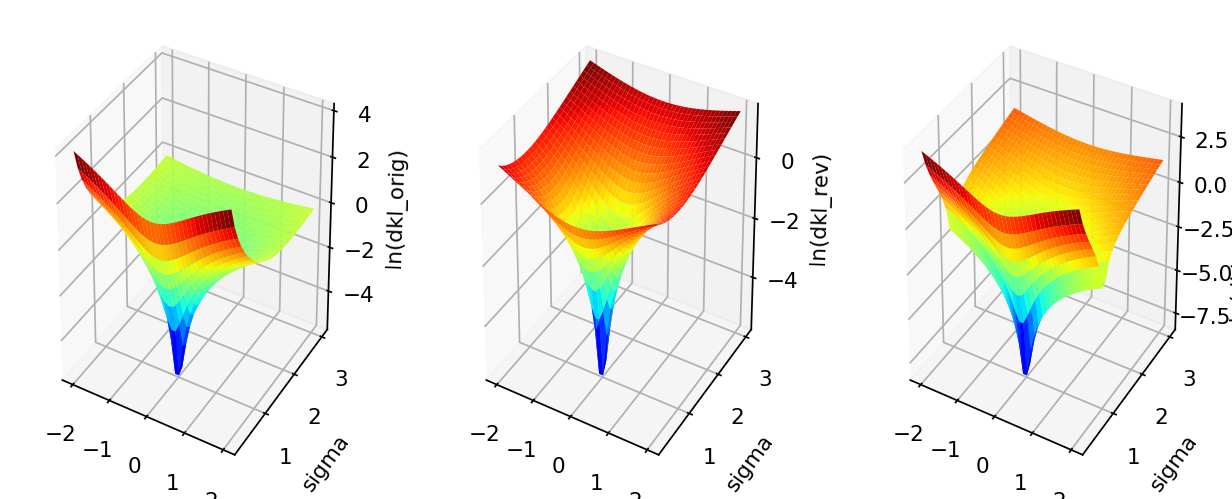

In [12]:
# Plot DKL of gaussian against uni-gaussian

import random
import numpy as np
import vae_tools.metrics as metrics


mean1 = 0
mean2 = 2
log_var1 = 0
log_var2 = 0
print(metrics.kl_loss(mean1, mean2, log_var1, log_var2))


mu_min = -2.
mu_max = 2.
sigma_min = .2
sigma_max = 3.
delta = 0.1

sigma =  list(np.linspace(sigma_min, sigma_max, int((sigma_max - sigma_min) / delta)))
mu = list(np.linspace(mu_min, mu_max, int((mu_max - mu_min) / delta)))

Sigma, Mu = np.meshgrid(sigma, mu)

dkl_orig = metrics.kl_loss(mean1, np.ravel(Mu), log_var1, 2.*np.log(np.ravel(Sigma)))
Dkl_orig = dkl_orig.reshape(Sigma.shape)
dkl_rev = metrics.kl_loss(np.ravel(Mu), mean1, 2.*np.log(np.ravel(Sigma)), log_var1)
Dkl_rev = dkl_rev.reshape(Sigma.shape)

from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
from matplotlib import cm
fig = plt.figure(figsize=(10,4), dpi=155)
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(Mu, Sigma, np.log(Dkl_orig), cmap=cm.jet, linewidth=0.1)
ax.set_xlabel('mu')
ax.set_ylabel('sigma')
ax.set_zlabel('ln(dkl_orig)')
ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(Mu, Sigma, np.log(Dkl_rev), cmap=cm.jet, linewidth=0.1)
ax.set_xlabel('mu')
ax.set_ylabel('sigma')
ax.set_zlabel('ln(dkl_rev)')
ax = fig.add_subplot(133, projection='3d')
ax.plot_surface(Mu, Sigma, np.log(np.abs(Dkl_rev - Dkl_orig)), cmap=cm.jet, linewidth=0.1)
ax.set_xlabel('mu')
ax.set_ylabel('sigma')
ax.set_zlabel('ln(dkl_rev + dkl_orig)')


plt.show()

In [13]:
# Plot DKL of gaussian against MoG